In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# https://www.akshare.xyz/zh_CN/latest/introduction.html
import akshare as ak
import json
import pandas as pd
import rui_risk_kit as rrk
import fastquotes
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

## Preparing Data

In [2]:
with open('assets.json','r') as myfile:
    data=myfile.read()

porfolio = json.loads(data)

# 构建开放式基金以及货币基金的列表
open_mutual_fund_list = []
currency_mutual_fund_list = []

for open_fund in porfolio['open_fund_in_porfolio']:
    open_mutual_fund_list.append(open_fund)

for currency_fund in porfolio['currency_fund_in_portfolio']:
    currency_mutual_fund_list.append(currency_fund)

In [3]:
currency_fund_info_df = rrk.get_currency_fund_values(currency_mutual_fund_list)
fund_em_info_df = rrk.get_mf_values(open_mutual_fund_list, indicator='累计净值走势')

# concatenate DataFrame(currency_fund_info_df) to Dataframe(fund_em_info_df)
fund_em_info_df = pd.concat([fund_em_info_df, currency_fund_info_df], axis=1)
portfolio_fund_list = open_mutual_fund_list + currency_mutual_fund_list
fund_em_info_df.tail()

,004342,163406,001714,003095,003096,161725,502056,005918,002963,213009,004972
净值日期,,,,,,,,,,,
2021-06-23,2.2370,8.0103,3.833,4.300,4.249,3.0790,1.6832,1.4357,1.2721,0.7385,0.7073
2021-06-24,2.2408,8.0160,3.832,4.191,4.141,3.0916,1.6567,1.4383,1.2672,0.5411,0.7277
2021-06-25,2.2749,8.0829,3.863,4.312,4.260,3.1216,1.7038,1.4616,1.2680,0.5438,0.7671
2021-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7664
2021-06-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7664


In [4]:
# 获取基金规模，代表基金的市值，该数据每季度更新一次
mcaps = {}
for fund in portfolio_fund_list:
    mcaps[fund] = fastquotes.fund.daily.fund_size(fund) * 100000000
mcaps

{'004342': 66000000.0,
 '163406': 26950000000.0,
 '001714': 14803000000.0,
 '003095': 19506000000.0,
 '003096': 20480000000.0,
 '161725': 49914000000.0,
 '502056': 279000000.0,
 '005918': 3744000000.0,
 '002963': 2888000000.0,
 '213009': 11915000000.0,
 '004972': 13032000000.0}

In [5]:
market_prices = ak.stock_zh_index_daily_tx(symbol="sh000300")
market_prices = market_prices.drop(market_prices.columns[[0, -1, -2, -3]], axis = 1)
market_prices.tail()

100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


,close
date,
2021-06-21,5090.39
2021-06-22,5122.16
2021-06-23,5147.39
2021-06-24,5155.97
2021-06-25,5239.97


## Constructing the prior

In [6]:
S = risk_models.CovarianceShrinkage(fund_em_info_df.dropna()).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

close    1.682435
dtype: float64

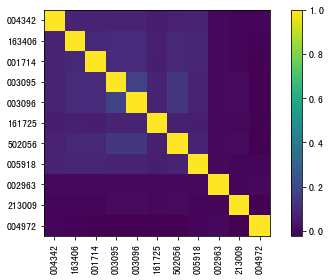

In [7]:
plotting.plot_covariance(S, plot_correlation=True);

In [8]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

001714   NaN
002963   NaN
003095   NaN
003096   NaN
004342   NaN
004972   NaN
005918   NaN
161725   NaN
163406   NaN
213009   NaN
502056   NaN
close    NaN
dtype: float64

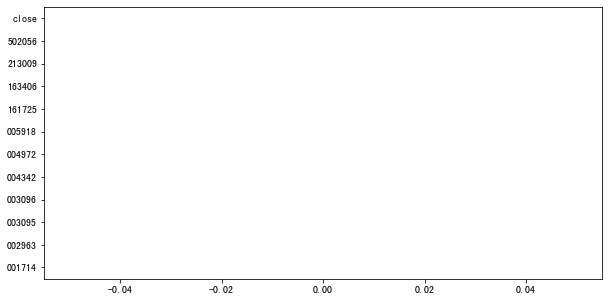

In [9]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [11]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [12]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [13]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

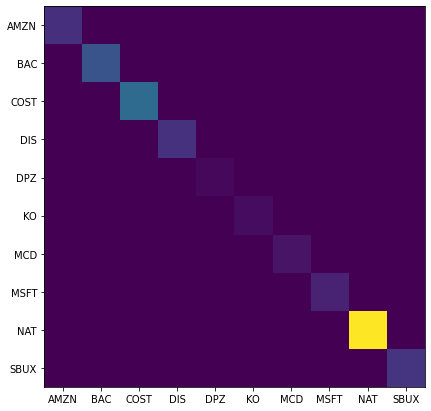

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [15]:
np.diag(bl.omega)

array([0.0045905 , 0.00898597, 0.01212048, 0.00498592, 0.00080656,
       0.00116796, 0.00175348, 0.00344722, 0.03449912, 0.00538453])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [16]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [17]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [18]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [19]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AMZN    0.162904
BAC     0.135479
COST    0.060633
DIS     0.074979
DPZ     0.101862
KO      0.007067
MCD     0.104183
MSFT    0.102650
NAT     0.060905
SBUX    0.083113
dtype: float64

We can visualise how this compares to the prior and our views:

In [20]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.188493,0.162904,0.10
BAC,0.103315,0.135479,0.30
COST,0.075241,0.060633,0.05
DIS,0.097337,0.074979,0.05
DPZ,0.047762,0.101862,0.20
KO,0.062470,0.007067,-0.05
MCD,0.067165,0.104183,0.15
MSFT,0.131621,0.102650,0.10
NAT,0.051900,0.060905,0.50
SBUX,0.080227,0.083113,0.10


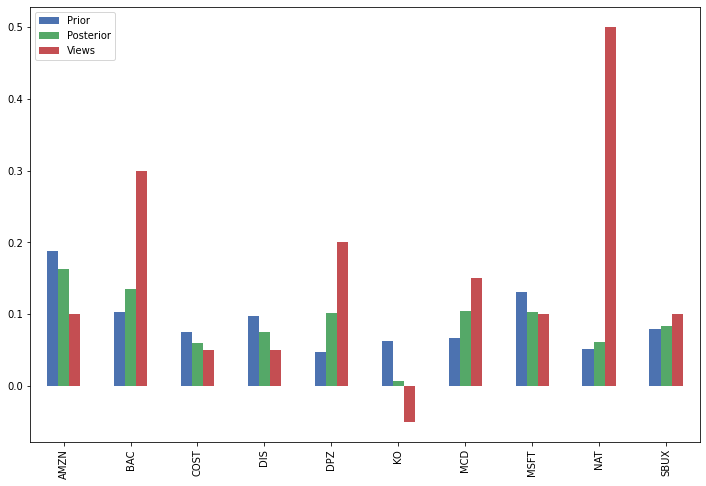

In [21]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

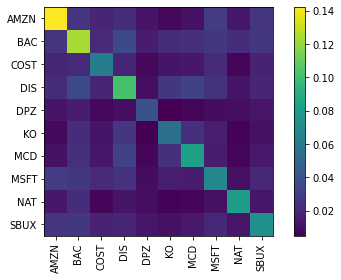

In [22]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [23]:
from pypfopt import EfficientFrontier, objective_functions

In [24]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/Users/Robert/github/PyPortfolioOpt/pypfopt/efficient_frontier.py:196: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AMZN', 0.20569),
             ('BAC', 0.1621),
             ('COST', 0.0521),
             ('DIS', 0.06778),
             ('DPZ', 0.129),
             ('KO', 0.0),
             ('MCD', 0.12415),
             ('MSFT', 0.11823),
             ('NAT', 0.05504),
             ('SBUX', 0.08591)])

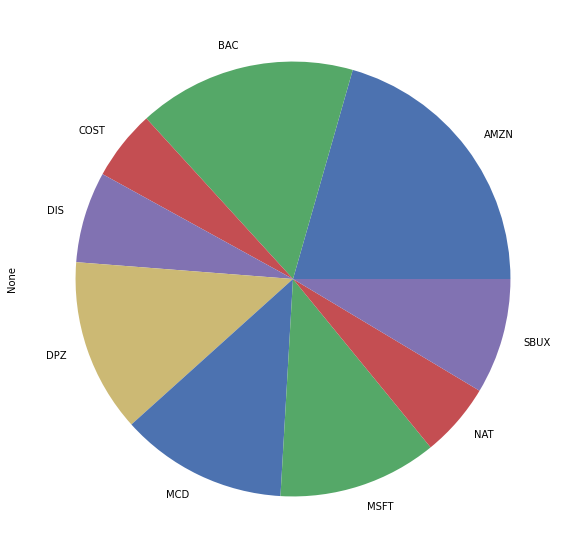

In [25]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [26]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $523.11


{'AMZN': 1,
 'BAC': 107,
 'COST': 3,
 'DIS': 8,
 'DPZ': 7,
 'MCD': 13,
 'MSFT': 10,
 'NAT': 387,
 'SBUX': 18}